# Closest unitary random MPO

Created 05/11/2024

Objectives:
* Sample MPO's randomly and check how close one can get to a unitary via a rescaling. We have an analytic formula for this.

# Package imports

In [1]:
import sys

In [2]:
sys.path.append("../../")

In [3]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os

In [4]:
from functools import reduce

In [78]:
import numpy as np
import pandas as pd
rng = np.random.default_rng()
import matplotlib.pyplot as plt

In [6]:
import re

In [7]:
from SPTOptimization.utils import (
    get_right_identity_environment_from_tp_tensor,
    to_npc_array
)

from SPTOptimization.SymmetryActionWithBoundaryUnitaries import SymmetryActionWithBoundaryUnitaries

# Definitons

In [8]:
NUM_SITES=5
BOND_DIMENSION=4
PHYSICAL_DIMENSION=2
LEARNING_RATE = 0.01

In [9]:
total_dimension = PHYSICAL_DIMENSION**NUM_SITES

In [10]:
left_trivial_leg_charge = tenpy.linalg.charges.LegCharge(
    tenpy.linalg.charges.ChargeInfo([], []),
    [0,1],
    [[]],
    qconj=1
)

In [11]:
right_trivial_leg_charge = tenpy.linalg.charges.LegCharge(
    tenpy.linalg.charges.ChargeInfo([], []),
    [0,1],
    [[]],
    qconj=-1
)

In [12]:
def generate_random_w_tensor(dims):
    x1 = np.random.rand(*dims)
    x2 = 1j*np.random.rand(*dims)

    return x1 + x2

In [13]:
edge_dims = [PHYSICAL_DIMENSION,]*2 + [BOND_DIMENSION,]
inner_dims = edge_dims + [BOND_DIMENSION,]

In [14]:
w = generate_random_w_tensor(edge_dims)

In [15]:
w_tensor = npc.Array.from_ndarray_trivial(w, labels=['p', 'p*', 'vR'])

In [16]:
w_tensor

<npc.Array shape=(2, 2, 4) labels=['p', 'p*', 'vR']>

In [17]:
w_tensors = [w_tensor,]

In [18]:
for _ in range(NUM_SITES-2):
    w = generate_random_w_tensor(inner_dims)
    w_tensor = npc.Array.from_ndarray_trivial(w, labels=['p', 'p*', 'vL', 'vR'])
    
    w_tensors.append(w_tensor)

In [19]:
w = generate_random_w_tensor(edge_dims)

In [20]:
w_tensor = npc.Array.from_ndarray_trivial(w, labels=['p', 'p*', 'vL'])

In [21]:
w_tensor

<npc.Array shape=(2, 2, 4) labels=['p', 'p*', 'vL']>

In [22]:
w_tensors.append(w_tensor)

In [23]:
w_tensors

[<npc.Array shape=(2, 2, 4) labels=['p', 'p*', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4) labels=['p', 'p*', 'vL']>]

## Functions

In [28]:
def get_physical_dim(tensor, p_label='p'):
    index = tensor.get_leg_index(p_label)
    dim = tensor.shape[index]
    return dim

In [29]:
def mpo_frobenius_inner_product(mpo1_tensors, mpo2_tensors=None):
    if mpo2_tensors is None:
        mpo2_tensors = mpo1_tensors

    w1 = mpo1_tensors[0]
    dim = get_physical_dim(w1, p_label='p')
    w2 = mpo2_tensors[0]

    t = npc.tensordot(w1, w2.conj(), [['p', 'p*'], ['p*', 'p']])
    #t /= dim

    for w1, w2 in zip(mpo1_tensors[1:], mpo2_tensors[1:]):
        dim = get_physical_dim(w1, p_label='p')

        t = npc.tensordot(t, w1, [['vR', ], ['vL']])
        t = npc.tensordot(t, w2.conj(), [['vR*', 'p', 'p*'], ['vL*', 'p*', 'p']])
        #t /= dim

    return t

In [30]:
def unitary_order_two_right_tensors(w_tensors):
    out = list()

    w = w_tensors[-1]
    t = npc.tensordot(w, w.conj(), [['p', 'p*'], ['p*', 'p']])

    out.append(t)

    for w in w_tensors[-2:0:-1]:
        t = npc.tensordot(t, w, [['vL',], ['vR']])
        t = npc.tensordot(t, w.conj(), [['vL*', 'p', 'p*'], ['vR*', 'p*', 'p']])

        out.append(t)

    return out[::-1]

In [31]:
def unitary_order_four_right_tensors(w_tensors):
    out = list()

    w = w_tensors[-1]
    t = npc.tensordot(w, w.conj(), [['p',], ['p*',]])
    t.ireplace_labels(['vL', 'vL*'], ['vL1', 'vL1*'])
    t = npc.tensordot(t, w, [['p',], ['p*',]])
    t = npc.tensordot(t, w.conj(), [['p', 'p*'], ['p*', 'p']])
    
    out.append(t)

    for w in w_tensors[-2:0:-1]:
        t = npc.tensordot(t, w, [['vL',], ['vR',]])
        t = npc.tensordot(t, w.conj(), [['vL*', 'p'], ['vR*', 'p*']])

        w = w.replace_label('vL', 'vL1')
    
        t = npc.tensordot(t, w, [['vL1', 'p',], ['vR', 'p*']])
        t = npc.tensordot(t, w.conj(), [['vL1*', 'p', 'p*'], ['vR*', 'p*', 'p']])

        out.append(t)

    return out[::-1]

In [32]:
w_tensors[-1].conj()

<npc.Array shape=(2, 2, 4) labels=['p*', 'p', 'vL*']>

In [33]:
def overlap_right_tensors(w_tensors, b_tensors):
    out = list()

    t = get_right_identity_environment_from_tp_tensor(b_tensors[-1])

    out.append(t)

    b = b_tensors[-1]
    w = w_tensors[-1]
    
    t = npc.tensordot(t, b, [['vL',], ['vR',]])
    t = npc.tensordot(
        t,
        w.conj().replace_label('vL*', 'vLm'),
        [['p',], ['p*',]]
    )
    t = npc.tensordot(t, b.conj(), [['p', 'vL*',], ['p*', 'vR*',]])

    out.append(t)

    for w, b in zip(w_tensors[-2:0:-1], b_tensors[-2:0:-1]):
        t = npc.tensordot(t, b, [['vL',], ['vR',]])
        t = npc.tensordot(
            t,
            w.conj().replace_label('vL*', 'vLm'),
            [['p', 'vLm'], ['p*', 'vR*']]
        )
        t = npc.tensordot(t, b.conj(), [['p', 'vL*',], ['p*', 'vR*',]])
    
        out.append(t)

    return out[::-1]

### Initialize tensors

In [34]:
def rescale_mpo_tensors(mpo_tensors, new_norm):
    num_sites = len(mpo_tensors)

    old_norm = mpo_frobenius_inner_product(mpo_tensors).real
    
    scale_factor = np.power(
        new_norm/old_norm,
        1/(2*num_sites)
    )

    for i in range(num_sites):
        mpo_tensors[i] = scale_factor*mpo_tensors[i]

In [35]:
def generate_random_w_tensor(physical_dim, left_virtual_dim=None,
                             right_virtual_dim=None):

    if (left_virtual_dim is None) and (right_virtual_dim is None):
        dims = (physical_dim, physical_dim)
    elif (left_virtual_dim is None):
        dims = (physical_dim, physical_dim, right_virtual_dim)
    elif (right_virtual_dim is None):
        dims = (physical_dim, physical_dim, left_virtual_dim)
    else: 
        dims = (
            physical_dim,
            physical_dim,
            left_virtual_dim,
            right_virtual_dim
        )
    
    X1 = rng.normal(size=dims)
    X2 = 1j*rng.normal(size=dims)
    X = X1 + X2

        
    if (left_virtual_dim is None) and (right_virtual_dim is None):
        out = npc.Array.from_ndarray_trivial(X, labels=['p', 'p*'])
    elif right_virtual_dim is None:
        out = npc.Array.from_ndarray_trivial(X, labels=['p', 'p*', 'vL'])
    elif left_virtual_dim is None:
        out = npc.Array.from_ndarray_trivial(X, labels=['p', 'p*', 'vR'])
    else:
        out = npc.Array.from_ndarray_trivial(
            X,
            labels=['p', 'p*', 'vL', 'vR']
        )

    return out

In [36]:
def get_random_mpo_tensors(num_sites, norm=None):
    """
    Needs more arguments
    """

    w = generate_random_w_tensor(edge_dims)
    w_tensor = npc.Array.from_ndarray_trivial(
        w,
        labels=['p', 'p*', 'vR']
    )

    w_tensors = [w_tensor,]

    for _ in range(num_sites-2):
        w = generate_random_w_tensor(inner_dims)
        w_tensor = npc.Array.from_ndarray_trivial(w, labels=['p', 'p*', 'vL', 'vR'])
        
        w_tensors.append(w_tensor)

    w = generate_random_w_tensor(edge_dims)
    w_tensor = npc.Array.from_ndarray_trivial(
        w,
        labels=['p', 'p*', 'vL']
    )
    w_tensors.append(w_tensor)

    if norm is not None:
        rescale_mpo_tensors(w_tensors, norm)

    return w_tensors

In [37]:
def get_identity_w_tensor(physical_dim, left_virtual_dim=None, right_virtual_dim=None):
    diagonal = np.ones(physical_dim, dtype='complex')
    identity_matrix = np.diag(diagonal)
    
    if (left_virtual_dim is None) and (right_virtual_dim is None):
        w_tensor = npc.Array.from_ndarray_trivial(
            identity_matrix,
            labels=['p', 'p*']
        )
    elif right_virtual_dim is None:
        X = np.zeros(
            (physical_dim, physical_dim, left_virtual_dim),
            dtype='complex'
        )
        X[...,0] = identity_matrix
        w_tensor = npc.Array.from_ndarray_trivial(
            X,
            labels=['p', 'p*', 'vL']
        )
    elif left_virtual_dim is None:
        X = np.zeros(
            (physical_dim, physical_dim, right_virtual_dim),
            dtype='complex'
        )
        X[...,0] = identity_matrix
        w_tensor = npc.Array.from_ndarray_trivial(
            X,
            labels=['p', 'p*', 'vR']
        )
    else:
        X = np.zeros(
            (physical_dim, physical_dim, left_virtual_dim, right_virtual_dim),
            dtype='complex'
        )
        X[...,0,0] = identity_matrix
        w_tensor = npc.Array.from_ndarray_trivial(
            X,
            labels=['p', 'p*', 'vL', 'vR']
        )

    return w_tensor

In [38]:
def get_random_mpo_tensors(physical_dims, virtual_dims):
    """
    Could fold in with get_identity_mpo_tensors
    """

    w_tensors = [
        generate_random_w_tensor(p_dim, *v_dims)
        for p_dim, v_dims in zip(physical_dims, virtual_dims)
    ]

    return w_tensors

In [39]:
def get_identity_mpo_tensors(physical_dims, virtual_dims):
    """
    Needs more comments, docs!

    Often physical dims, virtual dims will be the same, so could add
    optional behaviour...
    """

    w_tensors = [
        get_identity_w_tensor(p_dim, *v_dims)
        for p_dim, v_dims in zip(physical_dims, virtual_dims)
    ]

    return w_tensors

### Sweep function

In [40]:
def get_mpo_score(raw_gradient_mpo_tensor, gradient_target_tensor,
                  virtual_legs=[['vL*', 'vR*',], ['vR*', 'vL*',]]):
    # Calculate "score" (just the contraction of the two relevant tensors)
    # and add to score_list
    raw_legs, target_legs = virtual_legs

    score = npc.tensordot(
        raw_gradient_mpo_tensor,
        gradient_target_tensor.conj(),
        [['p', 'p*', *raw_legs], ['p*', 'p', *target_legs]]
    )

    return score.real

In [63]:
def get_unitary_scores(mpo_tensors, matrix_dim):
    right_unitary_two_tensors = unitary_order_two_right_tensors(mpo_tensors)
    right_unitary_four_tensors = unitary_order_four_right_tensors(mpo_tensors)

    w = mpo_tensors[0]
    t = right_unitary_two_tensors[0]

    grad_2 = npc.tensordot(t, w, [['vL'], ['vR',]])

    score_2 = get_mpo_score(grad_2, w, [['vL*',], ['vR*',]])

    # Fourth order terms
    t = right_unitary_four_tensors[0]
    grad_4 = npc.tensordot(t, w, [['vL'], ['vR',]])
    grad_4 = npc.tensordot(grad_4, w.conj(), [['vL*', 'p'], ['vR*', 'p*']])
    grad_4 = npc.tensordot(grad_4, w, [['vL1', 'p'], ['vR', 'p*']])

    score_4 = get_mpo_score(grad_4, w, [['vL1*',], ['vR*',]])

    unitarity_score = score_4 - 2*score_2 + matrix_dim
    min_score = 1 - (score_2**2)/(score_4*matrix_dim)

    return (min_score, unitarity_score, score_4, score_2, matrix_dim)

In [46]:
def unitarity_error_from_subscores(order_two_score, order_four_score, dimension):
    return order_four_score - 2*order_two_score + dimension

In [47]:
def unitarity_errors_from_subscores(order_two_scores, order_four_scores,
                                    dimension):
    out = [
        unitarity_error_from_subscores(o2, o4, dimension)
        for o2, o4 in zip(order_two_scores, order_four_scores)
    ]
    
    return out

# Test

## Identity test

In [64]:
num_sites = 2

In [65]:
total_dimension = 2**num_sites

In [66]:
physical_dims = [2,]*num_sites
virtual_dims = [(None, 1),] + [(1, None),]

In [67]:
X_1 = np.array([[[1,0],[0,-1]]])

In [68]:
X_1.shape

(1, 2, 2)

In [69]:
w_1 = npc.Array.from_ndarray_trivial(X_1, labels=['vR', 'p', 'p*'])

In [70]:
w_2 = get_identity_w_tensor(2, left_virtual_dim=1)

In [71]:
w_tensors = [w_1, w_2]

In [72]:
get_unitary_scores(w_tensors, total_dimension)

(0.0, 0.0, 4.0, 4.0, 4)

## Small sweep

In [73]:
sample_size = 1000
num_sites = 4
total_dimension = 2**num_sites
physical_dims = [2,]*num_sites
bond_dimension = 4
virtual_dims = [(None, 4),] + [(4,4)]*(num_sites - 2) + [(4, None),]

In [74]:
out = list()

for _ in range(sample_size):
    mpo_tensors = get_random_mpo_tensors(physical_dims, virtual_dims)
    out.append(get_unitary_scores(mpo_tensors, total_dimension))

In [75]:
out_array = np.array(out)

In [76]:
out_array

array([[5.99898754e-01, 2.84202256e+10, 2.84210787e+10, 4.26545360e+05,
        1.60000000e+01],
       [5.87670967e-01, 1.92329214e+09, 1.92351742e+09, 1.12649693e+05,
        1.60000000e+01],
       [7.13720668e-01, 1.08469248e+10, 1.08473706e+10, 2.22903674e+05,
        1.60000000e+01],
       ...,
       [6.46001727e-01, 7.39689282e+09, 7.39730219e+09, 2.04690291e+05,
        1.60000000e+01],
       [7.53243056e-01, 2.40021629e+10, 2.40027786e+10, 3.07840278e+05,
        1.60000000e+01],
       [6.15685186e-01, 9.56521874e+09, 9.56570378e+09, 2.42528074e+05,
        1.60000000e+01]])

In [79]:
pd.Series(out_array[:,0]).describe()

count    1000.000000
mean        0.672097
std         0.055037
min         0.531214
25%         0.632684
50%         0.675836
75%         0.710391
max         0.837899
dtype: float64

(array([ 17.,  70., 123., 154., 207., 211., 135.,  59.,  16.,   8.]),
 array([0.53121373, 0.56188229, 0.59255086, 0.62321942, 0.65388798,
        0.68455654, 0.7152251 , 0.74589367, 0.77656223, 0.80723079,
        0.83789935]),
 <BarContainer object of 10 artists>)

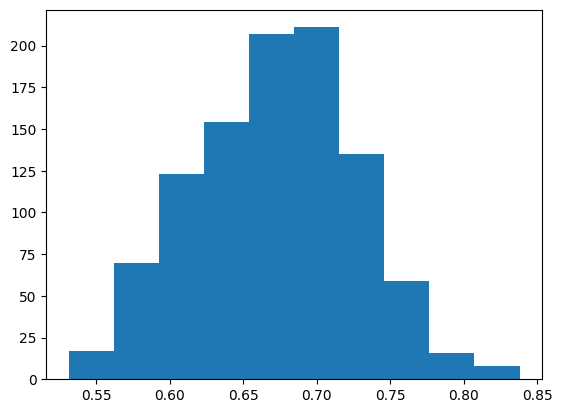

In [80]:
plt.hist(out_array[:,0])

In [81]:
pd.Series(out_array[:,1]).describe()

count    1.000000e+03
mean     1.558702e+10
std      1.619199e+10
min      4.703568e+08
25%      5.380900e+09
50%      1.057058e+10
75%      1.848000e+10
max      1.344801e+11
dtype: float64

(array([627., 229.,  67.,  38.,  18.,  11.,   7.,   0.,   1.,   2.]),
 array([4.70356753e+08, 1.38713300e+10, 2.72723033e+10, 4.06732766e+10,
        5.40742498e+10, 6.74752231e+10, 8.08761964e+10, 9.42771697e+10,
        1.07678143e+11, 1.21079116e+11, 1.34480089e+11]),
 <BarContainer object of 10 artists>)

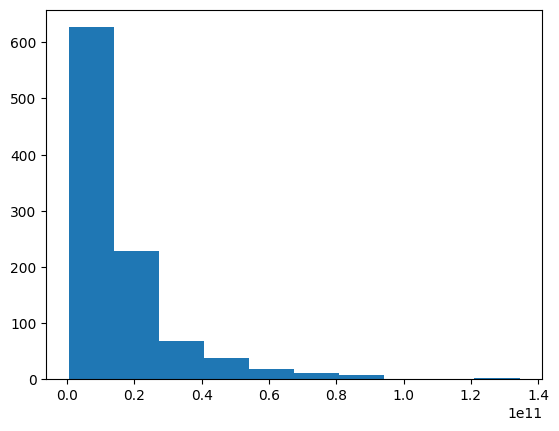

In [82]:
plt.hist(out_array[:,1])

# Sweep

In [85]:
bond_dimensions = list(range(1,6))
num_sites = list(range(2, 21, 2))

In [86]:
len(num_sites)*len(bond_dimensions)

50

In [87]:
sample_size = 500

In [92]:
out = list()

for n in num_sites:
    out.append(list())

    total_dimension = 2**n
    
    for b in bond_dimensions:
        print((n,b))

        out[-1].append(list())
        
        
        physical_dims = [2,]*n
        virtual_dims = [(None, b),] + [(b,b)]*(n - 2) + [(b, None),]

        for _ in range(sample_size):
            mpo_tensors = get_random_mpo_tensors(physical_dims, virtual_dims)
            out[-1][-1].append(get_unitary_scores(mpo_tensors, total_dimension))

(2, 1)
(2, 2)
(2, 3)
(2, 4)
(2, 5)
(4, 1)
(4, 2)
(4, 3)
(4, 4)
(4, 5)
(6, 1)
(6, 2)
(6, 3)
(6, 4)
(6, 5)
(8, 1)
(8, 2)
(8, 3)
(8, 4)
(8, 5)
(10, 1)
(10, 2)
(10, 3)
(10, 4)
(10, 5)
(12, 1)
(12, 2)
(12, 3)
(12, 4)
(12, 5)
(14, 1)
(14, 2)
(14, 3)
(14, 4)
(14, 5)
(16, 1)
(16, 2)
(16, 3)
(16, 4)
(16, 5)
(18, 1)
(18, 2)
(18, 3)
(18, 4)
(18, 5)
(20, 1)
(20, 2)
(20, 3)
(20, 4)
(20, 5)


In [93]:
out_array = np.array(out)

In [94]:
out_array.shape

(10, 5, 500, 5)

In [95]:
out_array[...,0]

array([[[0.70350297, 0.70553817, 0.66978099, ..., 0.48251303,
         0.56731839, 0.54074444],
        [0.58745181, 0.48396364, 0.71658094, ..., 0.66313308,
         0.67071612, 0.65880656],
        [0.55970465, 0.66479895, 0.42767414, ..., 0.47208698,
         0.37329063, 0.59089246],
        [0.40605033, 0.42767375, 0.59613621, ..., 0.52129911,
         0.54200117, 0.50976518],
        [0.35054426, 0.35649325, 0.63880633, ..., 0.5317601 ,
         0.54892017, 0.57068054]],

       [[0.8979764 , 0.70115097, 0.8758225 , ..., 0.84766074,
         0.85369254, 0.86425113],
        [0.84955696, 0.78828219, 0.86536251, ..., 0.73402074,
         0.83112549, 0.70672851],
        [0.68611566, 0.66350124, 0.62598498, ..., 0.63839679,
         0.61093373, 0.81200178],
        [0.67299763, 0.67061471, 0.63177418, ..., 0.74809789,
         0.65766204, 0.60628644],
        [0.62235625, 0.68286617, 0.59136461, ..., 0.66056349,
         0.67879543, 0.69164445]],

       [[0.88283265, 0.94983925, 0.9

In [97]:
out_mins = np.min(out_array[...,0], axis=-1)

In [99]:
out_mins

array([[0.16166591, 0.22299052, 0.21528336, 0.20098905, 0.26600067],
       [0.4552387 , 0.46754571, 0.53434513, 0.52938804, 0.53002985],
       [0.74121795, 0.74251851, 0.69492964, 0.66796893, 0.62841337],
       [0.89401716, 0.84085029, 0.79567431, 0.77065871, 0.72571736],
       [0.9321416 , 0.90655514, 0.86254363, 0.83652362, 0.80826689],
       [0.97554631, 0.93067318, 0.91603866, 0.88284627, 0.86149928],
       [0.98902123, 0.97042822, 0.94777087, 0.9186059 , 0.88553221],
       [0.99344981, 0.97356536, 0.96351173, 0.94098612, 0.92347977],
       [0.99796735, 0.989785  , 0.97669814, 0.96034957, 0.9393748 ],
       [0.99891079, 0.991749  , 0.98765655, 0.97302728, 0.95905113]])

In [100]:
out_means = np.mean(out_array[...,0], axis=-1)

In [101]:
out_means

array([[0.58687435, 0.54040964, 0.5103405 , 0.50056361, 0.50134613],
       [0.83251788, 0.75097214, 0.70769739, 0.67377499, 0.65338517],
       [0.92811251, 0.86744514, 0.81899939, 0.78436892, 0.7480354 ],
       [0.97106732, 0.93211626, 0.88630071, 0.85127924, 0.81980774],
       [0.98744627, 0.96146256, 0.93188774, 0.89990997, 0.87082927],
       [0.99499951, 0.97989115, 0.95732121, 0.93345854, 0.90727838],
       [0.99788595, 0.98914535, 0.97339748, 0.95443909, 0.93356051],
       [0.99916463, 0.99410456, 0.98377279, 0.96919837, 0.9524842 ],
       [0.9996113 , 0.99679718, 0.99007228, 0.97930648, 0.96523413],
       [0.99985981, 0.99827856, 0.99379353, 0.98604638, 0.97508189]])

In [102]:
out_vars = np.var(out_array[...,0], axis=-1)

In [103]:
out_vars

array([[1.07795961e-02, 9.05949877e-03, 7.30512051e-03, 6.78235803e-03,
        6.25364839e-03],
       [3.96582464e-03, 4.01802452e-03, 3.35848715e-03, 2.85669993e-03,
        2.62216537e-03],
       [1.22196236e-03, 1.34391793e-03, 1.49412228e-03, 1.40037430e-03,
        1.57993813e-03],
       [2.40104548e-04, 4.68306351e-04, 6.34245667e-04, 8.18830462e-04,
        8.74213328e-04],
       [5.95365394e-05, 1.95547918e-04, 3.14050443e-04, 4.30673284e-04,
        4.75140885e-04],
       [9.81764722e-06, 6.01684391e-05, 1.37813604e-04, 2.35670234e-04,
        2.74905906e-04],
       [2.24632910e-06, 1.98600944e-05, 7.06829370e-05, 1.12440025e-04,
        1.70257371e-04],
       [4.19838985e-07, 7.42485890e-06, 2.71289063e-05, 5.59589516e-05,
        8.91790815e-05],
       [8.88782606e-08, 2.53532973e-06, 1.14536722e-05, 3.19244887e-05,
        5.55836224e-05],
       [1.49511519e-08, 8.24716838e-07, 4.31050959e-06, 1.43887103e-05,
        2.90892534e-05]])

# Conclusions
* The score increeases strongly with the number of sites but seems to decrease slightly with bond dimension.
* Basically never "close" to unitaries.